## Спирина Татьяна DS-22
Домашнее задание 2

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:**

**- взять в тренировочный набор турниры с dateStart из 2019 года;**

**- в тестовый — турниры с dateStart из 2020 года.**


In [3]:
players = pd.read_pickle('/content/gdrive/MyDrive/chgk/players.pkl')
results = pd.read_pickle('/content/gdrive/MyDrive/chgk/results.pkl')
tournaments = pd.read_pickle('/content/gdrive/MyDrive/chgk/tournaments.pkl')


Посмотрим устройство данных словарей

In [ ]:
print(players[11])
print("Всего игроков: ", len(players))

{'id': 11, 'name': 'Наталья', 'patronymic': 'Юрьевна', 'surname': 'Абалымова'}
Всего игроков:  204063


In [7]:
tournaments[6131]

{'dateEnd': '2019-12-07T22:00:00+03:00',
 'dateStart': '2019-12-07T19:00:00+03:00',
 'id': 6131,
 'name': 'ДР Земцовского',
 'orgcommittee': [{'id': 66486,
   'name': 'Артём',
   'patronymic': 'Михайлович',
   'surname': 'Земцовский'},
  {'id': 76278,
   'name': 'Богдан',
   'patronymic': 'Денисович',
   'surname': 'Чадромцев'}],
 'questionQty': {'1': 23},
 'season': '/seasons/53',
 'synchData': None,
 'type': {'id': 2, 'name': 'Обычный'}}

In [6]:
results[6131]

[{'controversials': [],
  'current': {'name': 'Тема Земцовский',
   'town': {'id': 11, 'name': 'Архангельск'}},
  'flags': [],
  'mask': '01111001001011100100001',
  'position': 1,
  'questionsTotal': 11,
  'synchRequest': None,
  'team': {'id': 55606,
   'name': 'Искусство ухода',
   'town': {'id': 201, 'name': 'Москва'}},
  'teamMembers': [{'flag': 'К',
    'player': {'id': 66486,
     'name': 'Артём',
     'patronymic': 'Михайлович',
     'surname': 'Земцовский'},
    'rating': 10467,
    'usedRating': 10467}]},
 {'controversials': [],
  'current': {'name': 'Коля Дорофеев', 'town': {'id': 281, 'name': 'Рязань'}},
  'flags': [],
  'mask': '01000000011101110100100',
  'position': 2,
  'questionsTotal': 9,
  'synchRequest': None,
  'team': {'id': 76000,
   'name': 'Коля Дорофеев',
   'town': {'id': 281, 'name': 'Рязань'}},
  'teamMembers': [{'flag': None,
    'player': {'id': 113355,
     'name': 'Анастасия',
     'patronymic': 'Алексеевна',
     'surname': 'Мазурова'},
    'rating': 9

Results, по идее, представляет из себя словарь, где ключи - id турниров. Проверим, что их количество совпадает

In [ ]:
print(len(tournaments) == len(results), len(results))

True 5528


In [ ]:
tournaments_df = pd.DataFrame(tournaments).T[["id","name"]]
tournaments_df.rename(columns={"id": "tourn_id"}, inplace=True)

In [ ]:
tournaments_df

,tourn_id,name
1,1,Чемпионат Южного Кавказа
2,2,Летние зори
3,3,Турнир в Ижевске
4,4,Чемпионат Украины. Переходной этап
5,5,Бостонское чаепитие
...,...,...
6481,6481,Онлайн: 15:00 (а)Синхрон-lite. Лига старта. Эп...
6482,6482,Онлайн: 19:00 Зелёный шум
6483,6483,Онлайн: 19:00 (а)Синхрон-lite. Лига старта. Эп...
6484,6484,"Онлайн: 22:00 Не числом, а умением - 2 (NEW!)"


Определим Id тренировочных и тестовых соревнований. Среди 2019 и 2020 годов отбираем соревнования для которых есть поле mask и оно не None.
Кроме того, есть некоторое количество длительных турниров. Например, с датой начала в 2019г и окончания в 2020. Если не ошибаюсь, в таких годовых турнирах (Балтийский берег, например) отдельно рейтингуется каждый тур и команды играют не все турниры. Судя по всему, каждый тур таких соревнований записан отдельно. Поэтому соревнования, у которых поле mask не одинаковой длинны для всех команд тоже решено не включать в датасет.

In [ ]:
def find_game_id(year, tournaments, results):
  tournaments_idxs = []
  for id, tournament in tournaments.items():
    if tournament["dateStart"][:4] in [year]:
      if results[id]:
        if 'mask' in results[id][0]:
          if results[id][0]['mask'] is not None:
            for i in range(len(results[id])):
              if results[id][i]['mask'] is not None:
                if len(results[id][0]['mask']) != len(results[id][i]['mask']):
                  break
            else:
              tournaments_idxs.append(id)
  return tournaments_idxs

In [ ]:
tournaments_idxs = find_game_id('2019', tournaments, results)
tournaments_test_idxs = find_game_id("2020", tournaments, results)
print("Тренировочных соревнований: ", len(tournaments_idxs), "\n", "Тестовых соревнований: ", len(tournaments_test_idxs))

Тренировочных соревнований:  662 
 Тестовых соревнований:  169


**2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:**


**-  повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;**
**-  в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;**
**-   для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.** 

В ходе изучения данных, заметила, что поле mask иногда содержит не только 0 и 1, но и Х и ?. 
? присутствует только у части команд турнира, и в сумму правильных ответов команды не попадает, поэтому решила заменить его на 0. 
Х, похоже на снятие вопроса для всех команд. Отражаем это в формировании train.
Здесь я формировала таблицу Игрок-Вопрос-Ответ (1\0)


In [ ]:
# X_train = []
team_data = []
for game, values in results.items():
  if game in tournaments_idxs:
    for team in values:
      if team['mask'] is not None:
        total_q = len(team['mask'])
    
        for player in team['teamMembers']:
          for q in range(total_q):
            res = team['mask'][q]
            if res == "?":
              res = 0
            if res == "X":
              continue
              
            # X_train.append([player["player"]["id"], str(game) + "_" + str(q), int(res) ])
            team_data.append([team["team"]["id"], player["player"]["id"], str(game) + "_" + str(q), int(res)])

In [ ]:
team_data = pd.DataFrame(team_data, columns=["team_id", "player_id", "quest_id", "answer"])
X_train = team_data.drop(["team_id"], axis=1)

In [ ]:
X_train.shape

(16151967, 3)

In [ ]:
X_train.head()

,player_id,quest_id,answer
0,6212,4772_0,1
1,6212,4772_1,1
2,6212,4772_2,1
3,6212,4772_3,1
4,6212,4772_4,1


In [ ]:
y_train = np.array(X_train["answer"])
X_train = X_train.drop(["answer"], axis=1)

In [ ]:
train_players = np.unique(X_train["player_id"])
print("Число игроков в турнирах 2019г ", len(train_players))

Число игроков в турнирах 2019г  56937


In [ ]:
train_questions = np.unique(X_train["quest_id"])
print("Число вопросов в турнирах 2019г ", len(train_questions))

Число вопросов в турнирах 2019г  30852


Цель обучения модели - получить "силу" игроков, которая может быть получена как веса модели, если каждый игрок - это фича. Сначала казалось логичым посчитать какую-то условную сложность каждого вопроса(доля правильных ответов, например) и учитывать эту фичу в модели. Но фраза из задания "модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса" говорит о том, что сложность задаем не мы, а обучит модель. Тогда получается, что сложность кажадого вопроса тоже должна быть весами модели. Тогда итоговый X_train будет представлять из себя:

Наблюдение - Ответ_игрока_на_вопрос. 

Фичи - все игроки и все вопросы. 

Таргет - 0/1 ответ игрока на вопрос.

На этих данных обучим логистическую регрессию.
Вообще для варианта только с одним 2019 годом датасет еще выглядит подъемным, но от мысли потом попробовать обучить это на нескольких годах я отказалась.

In [ ]:
del tournaments

In [ ]:
from sklearn.preprocessing import OneHotEncoder
X_train = OneHotEncoder().fit_transform(X_train[['player_id', "quest_id"]])

In [ ]:
assert (X_train.shape[0] == y_train.shape[0])
assert (len(train_players) + len(train_questions) == X_train.shape[1])

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="saga", max_iter=500, n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=500, n_jobs=-1, solver='saga')

In [ ]:
lr.coef_

array([[ 0.75369085,  1.5945806 ,  1.13296277, ..., -0.51467572,
         5.03958303,  3.05567268]])

В обученной модели первая часть весов, равная количеству игроков турниров 2019 года, - условная сила данных игроков. Сформируем на основе этого итоговую таблицу

In [ ]:
power = pd.DataFrame({"id": train_players, "power": lr.coef_[0][:len(train_players)]})

In [ ]:
players_df = pd.DataFrame(players).T
players_df["full name"] = players_df["surname"]+" "+ players_df["name"]+" " +players_df["patronymic"]
players_data = players_df[["id", "full name"]]
power_result = pd.merge(power, players_data).sort_values(by="power", ascending=False)

In [ ]:
del players

In [ ]:
power_result.reset_index(drop=True).head(20)

,id,power,full name
0,27403,4.157330,Руссо Максим Михайлович
1,4270,4.030017,Брутер Александра Владимировна
2,28751,3.985443,Семушин Иван Николаевич
3,27822,3.896333,Савченков Михаил Владимирович
4,30270,3.816866,Спешков Сергей Леонидович
5,30152,3.816201,Сорожкин Артём Сергеевич
6,20691,3.698418,Мереминский Станислав Григорьевич
7,18036,3.642617,Левандовский Михаил Ильич
8,26089,3.599003,Прокофьева Ирина Сергеевна
9,22799,3.581302,Николенко Сергей Игоревич


Посмотрим на рейтинг с сайта на начало января 2020 года. 

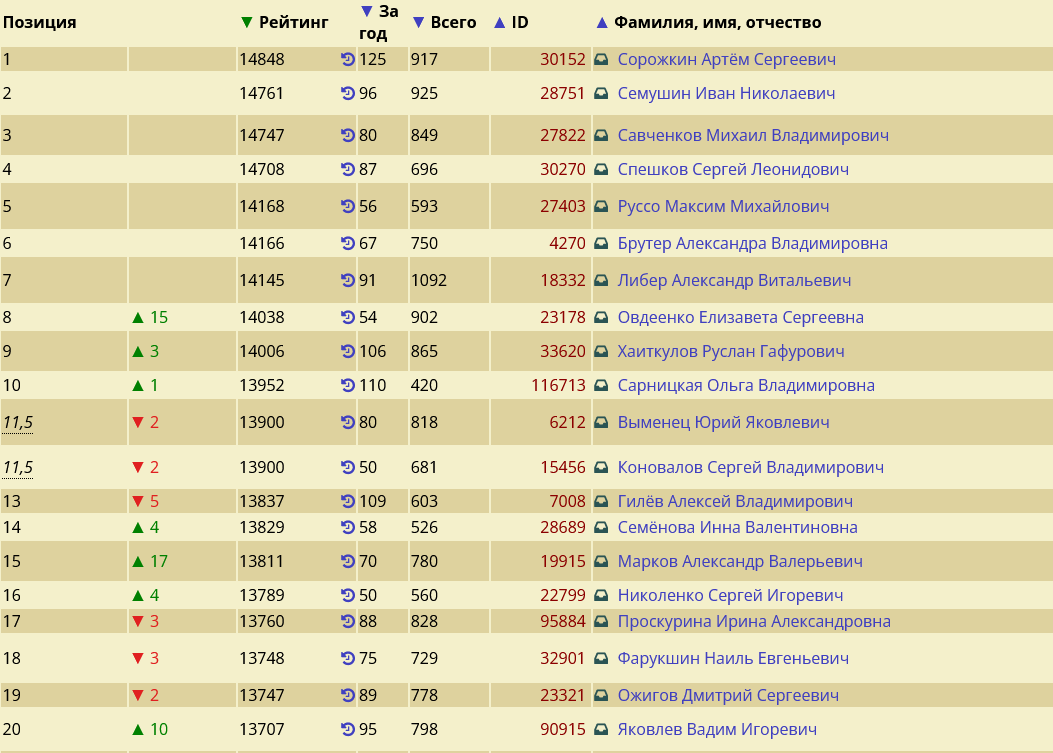

Получилось довольно похоже. У меня была мысль, что вообще нужно взять с сайта рейтинг, как если бы все начали играть в 2019 году, как в нашем трейне, но рейтинг на сайте рассчитывается не тривиально. Не стала развивать дальше эту идею.


**3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:**


**- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;**

**- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров**


Первая мысль - раз мы получили уже силу игроков в численном виде, то ей легко оперировать для сравнения сил команд. Я решила взять просто сумму этих сил для каждой команды и ранжировать по сумме. (Возможно, стоило бы смотреть медианы, но решила попробовать так)

In [ ]:
def game_ranks(participants, team_list, power):
  teams_power = {}
  for team in participants:
    cur_team_power = 0
    for player in team_list[team]:
      if (power['id']==player).any():
        cur_team_power += power[power["id"] == player].iloc[0]['power']
      else:
        cur_team_power += 0
        #здесь есть простор для рассуждений, новый игрок команды будет ли силы 0 или скорее какой-то доли от средней силы команды..
    teams_power[team] = cur_team_power

  sorted_teams = sorted(teams_power, key=teams_power.get, reverse=True) 
  predicted_ranks = [sorted_teams.index(i) + 1 for i in participants]
  return predicted_ranks

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

In [ ]:
def spearm_kend(tournaments_idxs, results, ranks_func):
  spearm = []
  kend = []
  for tournament in tournaments_idxs:
    team_result ={}
    team_list = {}
    for team in results[tournament]:
      team_result[team["current"]["name"]] = team["position"]
      team_list[team["current"]["name"]] = [i["player"]["id"] for i in team["teamMembers"]]

    sorted_teams = sorted(team_result, key=team_result.get) 
    predicted_ranks = ranks_func(sorted_teams, team_list, power)
    
    ranks = [team_result[i] for i in sorted_teams]
    corr_s, _ = spearmanr(predicted_ranks, ranks)
    corr_k, _ = kendalltau(predicted_ranks, ranks)

    spearm.append(corr_s)
    kend.append(corr_k)

  spearm = np.array(spearm)
  kend = np.array(kend)
  spearm = spearm[~np.isnan(spearm)]  
  kend = kend[~np.isnan(kend)]

  return np.mean(spearm), np.mean(kend)

In [ ]:
corr = spearm_kend(tournaments_test_idxs, results, game_ranks)
print("Корреляция Спирмена: ", corr[0])
print("Корреляция Кенделла: ", corr[1])

Корреляция Спирмена:  0.7786392754768656
Корреляция Кенделла:  0.6245885870615423


Сначала я удовлетворилась этим результатом, но, перейдя к 4му пункту, поняла, что необходимо было перейти к вероятностям. Ранжируем команды по вероятности ответа на какой-то абстрактный вопрос, сложность которого нам, кажется, не предположить. Вероятность ответа команды - вероятность, что хоть один игрок команды ответит правильно, то есть 1 минус вероятность, что все ответят неправильно.

Вероятность игрока ответить на средний вопрос = сигма(вес игрока + вес ср вопроса + константа)

In [ ]:
q_mean = np.mean(np.array(lr.coef_[0][len(train_players):]))
b = float(lr.intercept_)

In [ ]:
power["proba"] = 1 / (1 + np.exp(-power["power"] - q_mean - b))

In [ ]:
power

,id,power,proba
0,15,0.753695,0.289237
1,16,1.594585,0.485454
2,23,1.132959,0.372893
3,31,1.129964,0.372192
4,35,1.110672,0.367696
...,...,...,...
56932,224404,-0.863619,0.074716
56933,224408,-0.168797,0.139244
56934,224482,-0.523658,0.101886
56935,224539,0.846893,0.308766


In [ ]:
def game_ranks_proba(participants, team_list, power):
  teams_power = {}
  for team in participants:
    cur_team_proba = 1
    for player in team_list[team]:
      if (power['id']==player).any():
        cur_team_proba *= 1 - power[power["id"] == player].iloc[0]['proba']
        
      # else:
      #    cur_team_proba *= 0.5
      # сначала хотела предположить, что для неизвестного игрока вероятность 0.5
      # но результат вышел хуже, убрала эту ветку

    teams_power[team] = 1 - cur_team_proba

  sorted_teams = sorted(teams_power, key=teams_power.get, reverse=True) 
  predicted_ranks = [sorted_teams.index(i) + 1 for i in participants]
  return predicted_ranks

In [ ]:
corr = spearm_kend(tournaments_test_idxs, results, game_ranks_proba)
print("Корреляция Спирмена: ", corr[0])
print("Корреляция Кенделла: ", corr[1])

Корреляция Спирмена:  0.8091314548247555
Корреляция Кенделла:  0.653430877259729


Результат вышел лучше, чем с обычной суммой. Даже волнительно, не слишком ли высокий. 

**4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:**


**-предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные;**

**-не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;**

**- разработайте EM-схему для обучения этой модели, реализуйте её в коде;**

**- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики**



Е - шаг - вычисление ожидаемого значения вектора скрытых переменных, то есть вероятность игрока лично ответить на вопрос. 

М - шаг - максимизация правдоподобия и нахождение следующего приближения, в нашем случае - обучение модели по текущей вероятности ответа игрока на вопрос.

Изначально вероятность ответа игрока будем брать из бейзлайн модели 

Как упрощающие предположения для формирования значений скрытой переменной, можно постановить, что если команда, в которой играет игрок, не ответила на вопрос, то и вероятность игрока лично ответить - 0. (Вообще, тут я колебалась, тк есть ситуации, когда у команды в ходе обсуждения возникает правильный ответ, но капитан выбирает другой. Но спишем на эту же переменную вероятности и "умение надавить на капитана", как фактор успеха :) )

$$ p(z=1 |t_a=0) = 0 $$

$$ p(z=1 |t_a=1) = \frac{p(t_a=1|z=1)*p(z=1)}{p(t_a)=1} $$

Здесь так же сразу становится заметно еще одно упрощение: вероятность команды ответить правильно, если игрок ответил правильно (в нашем допущении идеальности капитана:) ) - 1. И формулу можно упростить. 

$$ p(z=1 |t_a=1) = \frac{1*p(z=1)}{p(t_a)=1} $$

Вероятность p(z=1) это вероятность ответа игрока лично, которую мы сначала берем на основе бейзлайна, а далее предсказываем на М-шаге

Вероятность p(t_a)=1 это та же история, что в пункте 3, рассмотренном через призму вероятностей (как раз в этот момент я поняла, что нужно вернуться к 3му пункту и реализовать ранжирование команд через вероятности игроков): Вероятность ответа команды - вероятность, что хоть один игрок команды ответит правильно, то есть 1 минус вероятность, что все ответят неправильно.

Тут я поняла, что не правильно изначально организовала данные, так как информация о том, в какой команде играл игрок в момент ответа на тот или иной вопрос к этому месту утеряна, и считала всё не самым эффективным образом. Моральных сил переделать принципиально схему данных не было, пришлось вернуться в начало городить костыли в виде доп таблиц.

Изначально пыталась для M-шага использовать логистическую регрессию, но не смогла победить ошибки в процессе реализации и взяла линейную.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def power_update(model):
  power = pd.DataFrame({"id": train_players, "power": model.coef_[:len(train_players)]})
  q_mean = np.mean(np.array(model.coef_[len(train_players):]))
  b = float(model.intercept_)
  power["proba"] = 1 / (1 + np.exp(-power["power"] - q_mean - b))
  return power

In [ ]:
def m_step(z):
  model = LinearRegression(n_jobs=-1)
  model.fit(X_train, np.log(z/(1-z)))
  p_z = model.predict(X_train)

  return 1/(1+np.exp(-p_z)), model

In [ ]:
def e_step(p_z, team_data):
  team_data["proba"] = p_z * y_train
  team_data["proba_0"] = 1 - p_z
  z = (team_data["proba"]/(1 - team_data.groupby(["team_id", "quest_id"])["proba_0"].transform('prod')))*team_data["answer"]
  z = np.clip(z, 1e-5, 1-1e-5)
  return z


In [ ]:
z0 = lr.predict_proba(X_train)[:, 1] * y_train


In [ ]:
# появлялась ошибка ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
print(np.all(np.isfinite(z0)))
print(np.any(np.isnan(z0)))
print(np.max(z0))
print(np.min(z0))

True
False
0.9995855070731469
0.0


В итоге поняла, что ошибка происходит в момент взятия логарифма от 0 и 1. Модифицирую допущение про вероятность игрока ответить 0. Тем более вспоминая про ошибку капитана, это вообще звучит логично.

In [ ]:
z0 = np.clip(z0, 1e-5, 1-1e-5)

In [ ]:
p_z, model = m_step(z0)
for i in range(5):
  z = e_step(p_z, team_data)
  p_z, model = m_step(z)
  power = power_update(model)
  corr = spearm_kend(tournaments_test_idxs, results, game_ranks_proba)
  print("Шаг", i + 2)
  print("Корреляция Спирмена: ", corr[0])
  print("Корреляция Кенделла: ", corr[1])


Шаг 2
Корреляция Спирмена:  0.8151493543540692
Корреляция Кенделла:  0.6604747078090737
Шаг 3
Корреляция Спирмена:  0.8181017155501455
Корреляция Кенделла:  0.6644801158256584
Шаг 4
Корреляция Спирмена:  0.8188342152811385
Корреляция Кенделла:  0.665493302376743
Шаг 5
Корреляция Спирмена:  0.8186336517076042
Корреляция Кенделла:  0.6656854166815582
Шаг 6
Корреляция Спирмена:  0.8183846158402307
Корреляция Кенделла:  0.6655148669456116


Относительно бейзлайна прирост не большой, но он есть! Рада этому несказанно.


**5. А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).**

Возьмем последнюю model, принципиально в плане весов ничего не менялось, у каждого вопроса есть вес, который рассматриваем как относительную сложность.

In [ ]:
quest_difficulty = pd.DataFrame({"id": train_questions, "difficulty": model.coef_[len(train_players):]})
quest_difficulty["tourn_id"] = [id.partition("_")[0] for id in quest_difficulty["id"]]
quest_difficulty = quest_difficulty.drop(["id"], axis=1).groupby("tourn_id").agg("median").reset_index()

In [ ]:
tournaments_df["tourn_id"] = [str(i) for i in tournaments_df["tourn_id"]]

In [ ]:
quest_difficulty = quest_difficulty.merge(tournaments_df, left_on="tourn_id", right_on="tourn_id").sort_values(by=["difficulty"])

In [ ]:
quest_difficulty.head(15)

,tourn_id,difficulty,name
653,6149,-5.591819,Чемпионат Санкт-Петербурга. Первая лига
534,5928,-4.466670,Угрюмый Ёрш
43,5159,-4.298831,Первенство правого полушария
223,5515,-4.035072,Чемпионат Минска. Лига А. Тур четвёртый
629,6101,-3.973172,Воображаемый музей
365,5684,-3.941718,Синхрон высшей лиги Москвы
545,5942,-3.819492,Чемпионат Мира. Этап 2. Группа В
546,5943,-3.740539,Чемпионат Мира. Этап 2 Группа С
587,5996,-3.740276,Тихий Донец: омут первый
544,5941,-3.734523,Чемпионат Мира. Этап 2. Группа А


In [ ]:
quest_difficulty.tail(15)

,tourn_id,difficulty,name
9,5011,3.511107,(а)Синхрон-lite. Лига старта. Эпизод IV
591,6003,3.529005,Второй тематический турнир имени Джоуи Триббиани
10,5012,3.613034,Школьный Синхрон-lite. Выпуск 2.5
539,5936,3.668232,Школьная лига. I тур.
380,5702,3.716794,(а)Синхрон-lite. Лига старта. Эпизод IX
376,5698,3.723640,(а)Синхрон-lite. Лига старта. Эпизод VII
557,5955,3.945520,Школьная лига. III тур.
633,6105,4.026487,Чемпионат МГУ. Открытая лига. Первый игровой день
526,5912,4.062430,Borisov Brain Cup
7,5009,4.130933,(а)Синхрон-lite. Лига старта. Эпизод III


Что-то непонятное с весами у One ring - async и вцелом какой-то странный турнир получается, 1 команда. Надо было его, наверно, изначально отловить и удалить. В остальном, наверно, похоже. Внизу школьные турниры, лига старта, в Топе Чемпионат Мира и лиги Спб и Мск. Звучит правдоподобно. "Угрюмый Ёрш" стало интересно, посмотрела на сайте, там у него название длиннее "Угрюмый Ёрш 2: Невыносимая сложность". Видимо, название дали справедливо.

In [ ]:
results[6102]

[{'controversials': [],
  'current': {'name': 'Два слова на букву К',
   'town': {'id': 2047, 'name': 'Гейдельберг'}},
  'flags': [],
  'mask': '111110000010111110100001011101000101',
  'position': 1,
  'questionsTotal': 19,
  'synchRequest': {'id': 72313, 'venue': {'id': 3361, 'name': 'Гейдельберг'}},
  'team': {'id': 55486,
   'name': 'Два слова на букву К',
   'town': {'id': 2047, 'name': 'Гейдельберг'}},
  'teamMembers': [{'flag': 'Б',
    'player': {'id': 132927,
     'name': 'Елена',
     'patronymic': 'Сергеевна',
     'surname': 'Шаповал'},
    'rating': 8122,
    'usedRating': 8122}]}]

Не совсем задание 6, но посмотреть что получилось по рейтингу игроков интересно

In [ ]:
power_result = pd.merge(power, players_data).sort_values(by="power", ascending=False)

In [ ]:
power_result.reset_index(drop=True).head(20)

,id,power,proba,full name
0,135951,13.306715,0.981845,Стетой Артём Феликсович
1,38175,13.276677,0.981301,Пилипенко Максим Игоревич
2,199963,12.472054,0.959137,Бровченко Елена Борисовна
3,22474,11.864390,0.927448,Немец Илья Сергеевич
4,133504,11.453561,0.894477,Лебедева София Евгеньевна
5,14996,11.047932,0.849627,Козлова Ольга Александровна
6,121433,10.765225,0.809841,Савенко София Романовна
7,202410,10.675194,0.795588,Подюкова Валентина
8,4876,9.998371,0.664212,Вакуленко Владимир Сергеевич
9,163668,9.884585,0.638379,Титов Георгий Михайлович


Результаты довольно не симпатичные. Получается, что высшую силу модель придает игрокам, кто играл буквально 1 турнир и сыграл его очень хорошо(посмотрела на сайте по некоторым игрокам). Но, с другой стороны, если мы смотрим исключительно на 2019год, то звучит отчасти логично. Но апгрейдить модель сил не хватило ни моральных ни ОЗУ 